# DATA ASSESSMENT
This notebook will be used to explore the data and plot some graphs.

In [61]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

---
## Messages dataset assessment

In [3]:
messages = pd.read_csv('../data/raw/disaster_messages.csv')
messages.head()

,id,message,original,genre
0,2,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [4]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 4 columns):
id          26248 non-null int64
message     26248 non-null object
original    10184 non-null object
genre       26248 non-null object
dtypes: int64(1), object(3)
memory usage: 820.4+ KB


***Observations:***
* Only 4 columns and 26K rows
* Missing values and only in the `original` feature
* `id` is numeric and corresponds obviously to a technical and unique id for all messages (we will ensure unicity after)
* `genre` is always the same for the first rows => let's plot all possible values with their number of occurrences

***Note:*** there are only missing values for `original` feature and when having a look at it we can see that sometimes the text is in french (for id 2 or 12 for example) and `message` is the translation of this message in english. We can guess that when `original` is empty then the message was originally in english. If this is right it probably means that this feature will not be needed in our use case and there are good chances that we can safely drop it.

#### Let's now ensure that all ids are unique within the dataset

In [6]:
assert messages.id.nunique() == messages.shape[0]

AssertionError: 

Interesting, it seems **there are duplicates in `id`**, let's check that more deeply.

In [10]:
messages[messages.id.duplicated()].id.value_counts()

24779    2
17919    1
6573     1
6492     1
25512    1
        ..
5573     1
7747     1
14592    1
15169    1
12416    1
Name: id, Length: 67, dtype: int64

In [17]:
messages[messages.id==24779]

,id,message,original,genre
21358,24779,Shelter materials (thick polyesters) are being...,NaN,news
21359,24779,Shelter materials (thick polyesters) are being...,NaN,news
21360,24779,Shelter materials (thick polyesters) are being...,NaN,news


**67 messages have duplicates** and one of them is even present 3 times. For sure **we will need to remove them**.  

#### Let's now focus on `genre` and see how many different values there are in the given dataset

In [18]:
messages.genre.value_counts()

news      13068
direct    10782
social     2398
Name: genre, dtype: int64

**Only 3 possible values for `genre`: news, direct and social.** Based on the use case, my understanding is that it describes kind of the source of the data: whether it comes from a direct call, from social networks or it is a news (newspapers, blog, whatever).

**Note:** we can observe NaN values in the `original` feature for the 3 above messages. Is there a pattern (like all 'news' are in english so original is empty)?

In [20]:
messages[messages.original.isnull()].genre.value_counts()

news      13068
social     2398
direct      598
Name: genre, dtype: int64

I was almost right: actually all messages with the genre news are in english so have empty original value but, and that's logic when you think about it, some other messages coming from direct calls or social media are already in english.  
Moreover, it will be easy to transform this feature into dummies as there are only 3 values.

**CONCLUSION**:
* There are some duplicates that will need to be removed
* `original` feature is the only one with empty values but information is redundant as the `message` feature corresponds to its translation in english.
* `genre` has only 3 values and will be easy to transform as dummies.
* so far I do not know how important it might be but there are far less 'direct' messages than 'news' or 'social' ones.

---
## Categories dataset assessment

In [21]:
categories = pd.read_csv('../data/raw/disaster_categories.csv')
categories.head()

,id,categories
0,2,related-1;request-0;offer-0;aid_related-0;medi...
1,7,related-1;request-0;offer-0;aid_related-1;medi...
2,8,related-1;request-0;offer-0;aid_related-0;medi...
3,9,related-1;request-1;offer-0;aid_related-1;medi...
4,12,related-1;request-0;offer-0;aid_related-0;medi...


In [22]:
categories.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26248 entries, 0 to 26247
Data columns (total 2 columns):
id            26248 non-null int64
categories    26248 non-null object
dtypes: int64(1), object(1)
memory usage: 410.2+ KB


***Observations:***
* There are the same number of rows than in the other dataset.
* There is also `id` feature so I guess this could be used to join/merge both datasets (will check whether duplicates are the same)
* Only 1 more feature: `categories` which seems to contain a semi-colon separated list of strings followed by a number.

#### Let's try to understand the `categories` column

In [24]:
categories.iloc[0].categories

'related-1;request-0;offer-0;aid_related-0;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-0;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-0;floods-0;storm-0;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0'

In [25]:
categories.iloc[1].categories

'related-1;request-0;offer-0;aid_related-1;medical_help-0;medical_products-0;search_and_rescue-0;security-0;military-0;child_alone-0;water-0;food-0;shelter-0;clothing-0;money-0;missing_people-0;refugees-0;death-0;other_aid-1;infrastructure_related-0;transport-0;buildings-0;electricity-0;tools-0;hospitals-0;shops-0;aid_centers-0;other_infrastructure-0;weather_related-1;floods-0;storm-1;fire-0;earthquake-0;cold-0;other_weather-0;direct_report-0'

It seems that this feature is a full list of all possible "classes" to classify a disaster followed, for each of them, by a binary 0/1 value to indicate whether this message belongs to this disaster category or not.  
Our goal will then be to split this feature into as many features as existing categories and put 0/1 for each of them. This will require a little bit of string manipulations but nothing too hard.

#### Are the `id` duplicates the same than in the messages dataset ?

In [23]:
categories[categories.id.duplicated()].id.value_counts()

24779    2
17919    1
6573     1
6492     1
25512    1
        ..
5573     1
7747     1
14592    1
15169    1
12416    1
Name: id, Length: 67, dtype: int64

Yes! So far, so good. Let's now merge datasets!

---
## Merging both and seeing what happens!

In [44]:
df = categories.merge(messages, on='id', how='inner')
df.head()

,id,categories,message,original,genre
0,2,related-1;request-0;offer-0;aid_related-0;medi...,Weather update - a cold front from Cuba that c...,Un front froid se retrouve sur Cuba ce matin. ...,direct
1,7,related-1;request-0;offer-0;aid_related-1;medi...,Is the Hurricane over or is it not over,Cyclone nan fini osinon li pa fini,direct
2,8,related-1;request-0;offer-0;aid_related-0;medi...,Looking for someone but no name,"Patnm, di Maryani relem pou li banm nouvel li ...",direct
3,9,related-1;request-1;offer-0;aid_related-1;medi...,UN reports Leogane 80-90 destroyed. Only Hospi...,UN reports Leogane 80-90 destroyed. Only Hospi...,direct
4,12,related-1;request-0;offer-0;aid_related-0;medi...,"says: west side of Haiti, rest of the country ...",facade ouest d Haiti et le reste du pays aujou...,direct


In [27]:
assert df.shape[0] == categories.shape[0]

AssertionError: 

Strange...what happened?

In [35]:
count_cat = categories.groupby(['id']).categories.count().sort_values(ascending=False).reset_index()
count_msg = messages.groupby(['id']).message.count().sort_values(ascending=False).reset_index()

In [41]:
global_count = pd.concat([count_cat, count_msg], axis=1)
global_count['diff'] = global_count.categories - global_count.message
global_count[global_count['diff'] != 0]

,id,categories,id,message,diff


In [45]:
df[df.id.duplicated()].id.value_counts()

24779    8
17919    3
7747     3
29022    3
19003    3
        ..
3217     3
5776     3
2446     3
18313    3
14592    3
Name: id, Length: 67, dtype: int64

Okayyyy....it's just me...  
Duplicated ids are still the same (the 67 ones) but during the merge operation, rows have been combined all together so a row that appears twice in both dataset will then appear 4 times (3 duplicates) in the merged dataset...  
**One smart way to avoid that would be to remove duplicates before the merge operation.**

#### Split `categories` into separate category columns.
1. Split the values in the `categories` column on the `;` character so that each value becomes a separate column.
2. Use the first row of categories dataframe to create column names for the categories data.
3. Rename columns of `categories` with new column names.
4. Convert category values to just numbers 0 or 1.

In [46]:
# 1. Create a new DataFrame with individual category columns
categories_split_df = df.categories.str.split(';', expand=True)
categories_split_df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [47]:
# 2. Use first row of the categories dataframe to extract a list of new column names for categories.
# This is done with lambda function and slicing on string
category_colnames = categories_split_df.iloc[0].str[:-2]
category_colnames

0                    related
1                    request
2                      offer
3                aid_related
4               medical_help
5           medical_products
6          search_and_rescue
7                   security
8                   military
9                child_alone
10                     water
11                      food
12                   shelter
13                  clothing
14                     money
15            missing_people
16                  refugees
17                     death
18                 other_aid
19    infrastructure_related
20                 transport
21                 buildings
22               electricity
23                     tools
24                 hospitals
25                     shops
26               aid_centers
27      other_infrastructure
28           weather_related
29                    floods
30                     storm
31                      fire
32                earthquake
33                      cold
34            

In [48]:
# 3. Rename the columns of `categories`
categories_split_df.columns = category_colnames
categories_split_df.head()

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
1,related-1,request-0,offer-0,aid_related-1,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-1,floods-0,storm-1,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
2,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
3,related-1,request-1,offer-0,aid_related-1,medical_help-0,medical_products-1,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0
4,related-1,request-0,offer-0,aid_related-0,medical_help-0,medical_products-0,search_and_rescue-0,security-0,military-0,child_alone-0,...,aid_centers-0,other_infrastructure-0,weather_related-0,floods-0,storm-0,fire-0,earthquake-0,cold-0,other_weather-0,direct_report-0


In [50]:
# Check it worked as expected
assert categories_split_df.shape[1] == len(category_colnames)

In [49]:
# 4. Convert category values to just numbers 0 or 1.
categories_split_df = categories_split_df.apply(lambda x: x.str[-1:].astype(int))
categories_split_df

,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,child_alone,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,0,0,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26383,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26384,1,0,0,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Replace `categories` column in merged dataset with new category columns

In [52]:
# Drop 'categories' and 'original' columns from merged dataset
df = df.drop(['categories', 'original'], axis=1)
# Then concatenate new `categories` dataframe
df = pd.concat([df, categories_split_df], axis=1)
df.head()

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
0,2,Weather update - a cold front from Cuba that c...,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,7,Is the Hurricane over or is it not over,direct,1,0,0,1,0,0,0,...,0,0,1,0,1,0,0,0,0,0
2,8,Looking for someone but no name,direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,9,UN reports Leogane 80-90 destroyed. Only Hospi...,direct,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,12,"says: west side of Haiti, rest of the country ...",direct,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [56]:
# Check the operation worked as expected
assert df.shape[1] == messages.shape[1] - 1 + categories_split_df.shape[1]

#### Remove duplicates

In [57]:
# Get the number of duplicates that should be removed after the operation and number of rows before the operation
nb_dups = df[df.duplicated()].shape[0]
nb_rows_before_drop_dup = df.shape[0]

# Drop duplicates and then check it worked as expected
df.drop_duplicates(inplace=True)

assert nb_rows_before_drop_dup - df.shape[0] == nb_dups

In [110]:
print("After duplicates removal, there are now {} rows in the merged dataset".format(df.shape[0]))

After duplicates removal, there are now 26216 rows in the merged dataset


---
## EDA part

In [59]:
df.describe()

,id,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,security,military,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
count,26216.00000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,...,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000,26216.000000
mean,15224.82133,0.773650,0.170659,0.004501,0.414251,0.079493,0.050084,0.027617,0.017966,0.032804,...,0.011787,0.043904,0.278341,0.082202,0.093187,0.010757,0.093645,0.020217,0.052487,0.193584
std,8826.88914,0.435276,0.376218,0.066940,0.492602,0.270513,0.218122,0.163875,0.132831,0.178128,...,0.107927,0.204887,0.448191,0.274677,0.290700,0.103158,0.291340,0.140743,0.223011,0.395114
min,2.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7446.75000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,15662.50000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,22924.25000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,30265.00000,2.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


***Observations:***
* We can see that classes are imbalanced and that will be an issue to deal with! For example the `related` category appears a lot (25% percentile is already 1) whereas for some others such as `request`, `offer` or `medical_help` even the 75% percentile is still 0.
* It seems we have some outliers as for example there is a max value=2 for the `related` category.

#### How many elements per class?

In [64]:
df_stats = df.drop(['id', 'message', 'genre'], axis=1)

In [97]:
df_stats.sum()

related                   20282
request                    4474
offer                       118
aid_related               10860
medical_help               2084
medical_products           1313
search_and_rescue           724
security                    471
military                    860
child_alone                   0
water                      1672
food                       2923
shelter                    2314
clothing                    405
money                       604
missing_people              298
refugees                    875
death                      1194
other_aid                  3446
infrastructure_related     1705
transport                  1201
buildings                  1333
electricity                 532
tools                       159
hospitals                   283
shops                       120
aid_centers                 309
other_infrastructure       1151
weather_related            7297
floods                     2155
storm                      2443
fire    

***Note:*** `child_alone` has no value so we can safely drop it as we will never learn to predict this category.

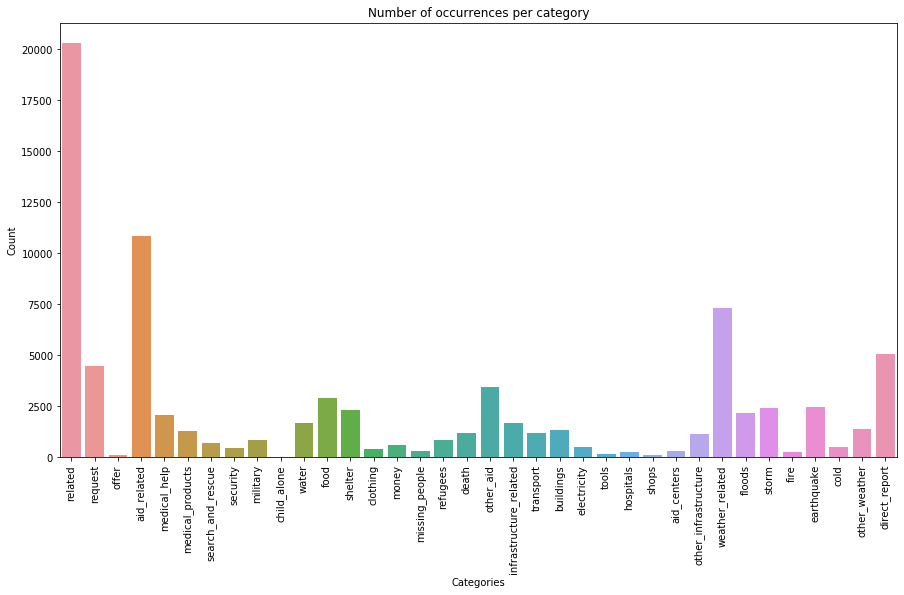

In [96]:
figure, axis = plt.subplots(1, 1, figsize=(15, 8))
axis.set_title("Number of occurrences per category")
sns.barplot(x=df_stats.columns, y=df_stats.sum(), ax=axis)
axis.set_ylabel("Count")
axis.set_xlabel("Categories")
axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
plt.show()

#### Looking for outliers

In [98]:
df_stats.max().sort_values(ascending=False)

related                   2
military                  1
missing_people            1
money                     1
clothing                  1
shelter                   1
food                      1
water                     1
security                  1
other_weather             1
search_and_rescue         1
medical_products          1
medical_help              1
aid_related               1
offer                     1
request                   1
refugees                  1
direct_report             1
other_aid                 1
infrastructure_related    1
cold                      1
earthquake                1
fire                      1
storm                     1
floods                    1
weather_related           1
other_infrastructure      1
aid_centers               1
shops                     1
hospitals                 1
tools                     1
electricity               1
buildings                 1
transport                 1
death                     1
child_alone         

OK **there is only the `related` feature which has a max value to 2**. Let's see how many messages have this max value:

In [100]:
df[df['related'] == 2]

,id,message,genre,related,request,offer,aid_related,medical_help,medical_products,search_and_rescue,...,aid_centers,other_infrastructure,weather_related,floods,storm,fire,earthquake,cold,other_weather,direct_report
117,146,Dans la zone de Saint Etienne la route de Jacm...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
221,263,. .. i with limited means. Certain patients co...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
307,373,The internet caf Net@le that's by the Dal road...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
462,565,"Bonsoir, on est a bon repos aprs la compagnie ...",direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
578,700,URGENT CRECHE ORPHANAGE KAY TOUT TIMOUN CROIX ...,direct,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20465,23662,transferred to a sanitary landfill site by a,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
20636,23861,Families also have solar lamps which can be re...,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
22481,25874,Read the [full blog post](http://www.odi.org.u...,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23537,27071,Actualmente e independientemente de la ayuda d...,news,2,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


***Observations:***
* There are still messages in french! For example the first row, this is weird as I first thought that `message` would contain the original message translated into english. I will check later with this specific one.
* I have the feeling that when `related` equals 2 then all other features are 0, so perhaps we could also drop those rows?

#### What was the original message for id=146?

In [108]:
messages[messages['id'] == 146].original.values

array(['Nan zon st. etine rout jakmel la bloke se mize pr nou al jakmel'],
      dtype=object)

Ouch! Using Google translation service with auto-detection language we can see that the original message is in [Haitian Creole](https://en.wikipedia.org/wiki/Haitian_Creole).  
This will be an issue as **in the end we are not sure that all messages are translated in english**. So performing some NLP tasks will be quite messy when message is not in english...

#### Are there detected categories when `related` is 2?

In [109]:
df_stats[df_stats['related'] ==2].max().sort_values(ascending=False)

related                   2
other_weather             0
missing_people            0
money                     0
clothing                  0
shelter                   0
food                      0
water                     0
child_alone               0
military                  0
security                  0
search_and_rescue         0
medical_products          0
medical_help              0
aid_related               0
offer                     0
request                   0
refugees                  0
direct_report             0
other_aid                 0
other_infrastructure      0
cold                      0
earthquake                0
fire                      0
storm                     0
floods                    0
weather_related           0
aid_centers               0
infrastructure_related    0
shops                     0
hospitals                 0
tools                     0
electricity               0
buildings                 0
transport                 0
death               

The answer is **no**. We will learn nothing with those 188 rows as all categories are set to 0.  
188 rows represents 0.7% of the data so we could safely drop those rows.

Wait a minute, and what about when the `related` value is 0?

In [112]:
df_stats[df_stats['related'] ==0].max().sort_values(ascending=False)

direct_report             0
other_weather             0
missing_people            0
money                     0
clothing                  0
shelter                   0
food                      0
water                     0
child_alone               0
military                  0
security                  0
search_and_rescue         0
medical_products          0
medical_help              0
aid_related               0
offer                     0
request                   0
refugees                  0
death                     0
other_aid                 0
other_infrastructure      0
cold                      0
earthquake                0
fire                      0
storm                     0
floods                    0
weather_related           0
aid_centers               0
infrastructure_related    0
shops                     0
hospitals                 0
tools                     0
electricity               0
buildings                 0
transport                 0
related             

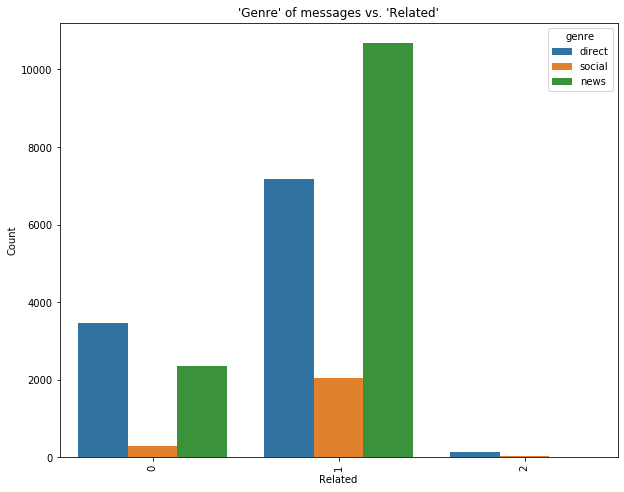

In [131]:
figure, axis = plt.subplots(1, 1, figsize=(10, 8))
axis.set_title("'Genre' of messages vs. 'Related'")
sns.countplot(x='related', hue='genre', data=df)
axis.set_ylabel("Count")
axis.set_xlabel("Related")
axis.set_xticklabels(axis.get_xticklabels(), rotation=90)
plt.show()

***Observations:***  
There are more samples which are "not related" than those with related=2. **It is important to keep this information related=0 so it can help us to classify as "not related" otherwise our model will try to classify into one of the others categories** and that is not something that we want. We would like to be able to filter messages that are not disaster related so we do not treat them.  
Instead of dropping the related=2 samples, I will convert their related value to 0.

---
# CONCLUSION
After this data assessment part here are the transformations we will apply on the merge dataset:
* drop the `child_alone` feature as it has no sample in this dataset
* convert rows where `related` is 2 into related=0 as all others categories have a 0 value.